In [1]:
print("hello")

hello


In [2]:
import sys
sys.executable

import argparse
import os
import shutil
import time
import numpy as np
import torch
from torch_geometric.data import Batch
from torch_geometric.transforms import Compose
from torch_scatter import scatter_sum, scatter_mean
from tqdm.auto import tqdm
import utils.misc as misc
import utils.transforms as trans
from datasets import get_dataset
from datasets.pl_data import FOLLOW_BATCH
from models.molopt_score_model import ScorePosNet3D, log_sample_categorical
from utils.evaluation import atom_num
from rdkit.Chem import AllChem
from utils import reconstruct, transforms
import pdb
from rdkit.Chem import rdForceFieldHelpers
import copy
import argparse
import os
import shutil
import numpy as np
import torch
import torch.utils.tensorboard
from sklearn.metrics import roc_auc_score
from torch.nn.utils import clip_grad_norm_
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose
from tqdm.auto import tqdm
import utils.misc as misc
import utils.train as utils_train
import utils.transforms as trans
from datasets import get_dataset
from datasets.pl_data import FOLLOW_BATCH
from models.molopt_score_model import ScorePosNet3D
import pdb
import multiprocessing 
from utils.reconstruct import reconstruct_from_generated
from datetime import datetime
from rdkit import RDLogger
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
RDLogger.DisableLog('rdApp.*')   


print("import completed")

import completed


In [21]:


def get_energy(ligand_element, ligand_pos, protein_element, protein_pos):
    energy = 1e7
    pos_combined = np.concatenate(( ligand_pos,protein_pos)).tolist()
    atom_combined = np.concatenate((ligand_element, protein_element )).tolist()
    # print(pos_combined)
    try:
        mol = reconstruct_from_generated(pos_combined,atom_combined)
        mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(mol)

        if mp == None:
            energy = 1e7
            return energy
        # we set all of these to the default which is True
            # mp.SetMMFFBondTerm(False)
            # mp.SetMMFFAngleTerm(False)
            # mp.SetMMFFStretchBendTerm(False)
            # mp.SetMMFFTorsionTerm(False)
            # mp.SetMMFFOopTerm(False)
            # mp.SetMMFFVdWTerm(False)
        ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(mol, mp,nonBondedThresh=100)

        energy = ff.CalcEnergy()
    except:
        energy = 1e7
        pass
    
    return energy


def recover_pos(batch, r_out):
    batch_indicator = batch.ligand_element_batch
    idx = set(batch_indicator.tolist())
    pointer, ligand_pos2, ligand_atom2 = 0, [], []
    for i in idx:
        ligand_pos2.append(r_out["pos"][pointer:(pointer + len(batch_indicator[batch_indicator == i]))])
        ligand_atom2.append(batch[i].ligand_element)
        pointer += len(batch_indicator[batch_indicator == i])
        
    return copy.copy(ligand_pos2), copy.copy(ligand_atom2)
    
    
def decoder(model, batch, emb3d):
    sigma = 1
    mu = 0
    batch_ligand = batch.ligand_element_batch

    batch_protein = batch.protein_element_batch
    center_pos = scatter_mean(batch.protein_pos, batch_protein, dim=0)
    batch_center_pos = center_pos[batch_ligand]
    init_ligand_pos = batch_center_pos + torch.randn_like(batch_center_pos) * sigma + mu
    batch_ligand = batch.ligand_element_batch
    ligand_num_atoms = scatter_sum(torch.ones_like(batch_ligand), batch_ligand, dim=0).tolist()
    
    #print(torch.mean(batch[0].protein_pos, dim = 0))
    #print(torch.mean(init_ligand_pos[batch_ligand == 0], dim = 0))
    r = model.reconstruc_3d(
        protein_pos=batch.protein_pos,
        protein_v=batch.protein_atom_feature.float(),
        batch_protein=batch.protein_element_batch,

        init_ligand_pos=init_ligand_pos,
        emb_lat=emb3d,
        init_ligand_v=batch.ligand_atom_feature_full,
        batch_ligand=batch.ligand_element_batch,
        num_steps=20,

        pos_only=True,
        center_pos_mode="protein"
    )
    return r


all_pose_ligand = []
all_pose_protein = []
all_atom_ligand = []
all_atom_protein = []

def gpu_func2( sel):
    e = get_energy(all_atom_ligand[sel], all_pose_ligand[sel], all_atom_protein[sel], all_pose_protein[sel])
    return e


def gpu_func_ground_truth( sel):
    e = get_energy(train_set[sel].ligand_element.detach().cpu().numpy(), train_set[sel].ligand_pos.detach().cpu().numpy(),  train_set[sel].protein_element.detach().cpu().numpy(), train_set[sel].protein_pos.detach().cpu().numpy())
    return e


def get_energy_based_loss():
    ## -----------------  calculating the center of the prediction and using the original topology--------------------------------

    predicted_centers = []
    for lig in ligand_pos:
        c = torch.mean(lig, dim=0)
        predicted_centers.append(c)

    print("predicted center: ", predicted_centers[0])
    batch_protein = batch.protein_element_batch
    ground_truth_centers = scatter_mean(batch.protein_pos, batch_protein, dim=0)
    print("ground truth center: ",ground_truth_centers[0])


    ground_truth_centers = ground_truth_centers.detach().cpu().numpy()
    ## -----------------  calculating the center of the prediction and using the original topology--------------------------------

    ## -----------------  we use predicted location for rigid docking --------------------------------
    debug = False

    global all_pose_ligand 
    global all_pose_protein
    global all_atom_ligand 
    global all_atom_protein

    all_pose_ligand = []
    all_pose_protein = []
    all_atom_ligand = []
    all_atom_protein = []

    for sel_pocket in range(len(batch)):
        mov_vec = ground_truth_centers[sel_pocket] - predicted_centers[sel_pocket].detach().cpu().numpy()

        pos_l, pos_p = train_set[sel_pocket].ligand_pos.detach().cpu().numpy() +  mov_vec, train_set[sel_pocket].protein_pos.detach().cpu().numpy()
        x_l, x_p     = train_set[sel_pocket].ligand_element.detach().cpu().numpy(), train_set[sel_pocket].protein_element.detach().cpu().numpy()

        all_pose_ligand.append(pos_l)
        all_pose_protein.append(pos_p)

        all_atom_ligand.append(x_l)
        all_atom_protein.append(x_p)


        if debug:
            print("=== ")
            print("predicted  center: ", np.mean(pos_l,axis=0))
            print("ground truth center: ",ground_truth_centers[sel_pocket])
            print("=== ")


    pos_combined = np.concatenate((pos_l,pos_p))
    atom_combined = np.concatenate((x_l, x_p))


    print("sample protein Center", np.mean(pos_p, axis = 0))
    print("sample ligand Center",np.mean(pos_l, axis = 0))

    
    # ===================== calculating number of feasible structure success rate =============================
    
    failure_counter = 0
    for i in range(len(batch)):
        select_pocket = i
        e = get_energy(all_atom_ligand[select_pocket], all_pose_ligand[select_pocket], all_atom_protein[select_pocket], all_pose_protein[select_pocket])
        # print(e)
        if e == 1e7:
            failure_counter +=1
            print("============ infeasible structure")
            continue 
        pos_combined = np.concatenate((all_pose_ligand[select_pocket], all_pose_protein[select_pocket])).tolist()
        atom_combined = np.concatenate((all_atom_ligand[select_pocket], all_atom_protein[select_pocket])).tolist()
    
    print("done", "success rate is: ", (len(batch) - failure_counter)/len(batch))
    
    # ===================== calculating number of feasible structure success rate =============================

    # ===================== calculating energy for both prediction and ground truth with multiplrocessing on CPU =============================



    pool_obj = multiprocessing.Pool()
    all_energy = [] 
    ### calculate energy for prediction
    for i in range(1):
        k = 100*i
        ans = pool_obj.map(gpu_func2, range(0, k+100))
        all_energy.extend(ans)
    print("energy done for prediction")    
    ### calculate energy for ground truth
    all_energy_ground_truth = [] 
    for i in range(1):
        k = 100*i
        ans = pool_obj.map(gpu_func_ground_truth, range(0, k+100))
        all_energy_ground_truth.extend(ans)
    print("energy done for ground truth")    
    
    
    # ===================== calculating energy for both prediction and groung truth with multiplrocessing on CPU =============================
    # ===================== get energy loss =============================

    def get_energy_loss(predicted_energy, ground_truth_energy):
        predicted_energy[ground_truth_energy==1e7] = ground_truth_energy[ground_truth_energy==1e7] # if ground truth energy is faulty lets ignore it 
        ground_truth_energy[predicted_energy==1e7] = predicted_energy[predicted_energy==1e7] # we need to change this line later

        return 10*np.log(np.abs(predicted_energy - ground_truth_energy)+1)
    
    
    loss = get_energy_loss(np.array(all_energy), np.array(all_energy_ground_truth))
    
    return loss
    # ===================== get energy loss =============================

    

  
    
    

In [22]:
import argparse
import os
import shutil

import numpy as np
import torch
import torch.utils.tensorboard
from sklearn.metrics import roc_auc_score
from torch.nn.utils import clip_grad_norm_
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose
from tqdm.auto import tqdm

import utils.misc as misc
import utils.train as utils_train
import utils.transforms as trans
from datasets import get_dataset
from datasets.pl_data import FOLLOW_BATCH
from models.molopt_score_model import ScorePosNet3D
import pdb

# if __name__ == '__main__':
parser = argparse.ArgumentParser()
parser.add_argument('config', type=str)
# parser.add_argument('-i', '--data_id', type=int)
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--result_path', type=str, default='./outputs')
parser.add_argument('--data_id', type=int, default=0)
args, unknown = parser.parse_known_args()

logger = misc.get_logger('sampling')

# Load config

config = misc.load_config("/scratch/user/alighazi/bioprj/LDM-3DG/mycode/AE_Geometry_and_Conditional_Latent_Diffusion/configs/sampling.yml")
# print(args.config)

logger.info(config.sample)
misc.seed_all(config.sample.seed)

# Load checkpoint
ckpt = torch.load(config.model.checkpoint, map_location=args.device)
logger.info(f"Training Config: {ckpt['config']}")
# Transforms
protein_featurizer = trans.FeaturizeProteinAtom()
ligand_atom_mode = ckpt['config'].data.transform.ligand_atom_mode
ligand_featurizer = trans.FeaturizeLigandAtom(ligand_atom_mode)
transform = Compose([
    protein_featurizer,
    ligand_featurizer,
    trans.FeaturizeLigandBond(),
])

# Load dataset
dataset, subsets = get_dataset(
    config=ckpt['config'].data,
    transform=transform
)
train_set, test_set = subsets['train'], subsets['test']
logger.info(f'Successfully load the dataset (size: {len(test_set)})!')


collate_exclude_keys = ['ligand_nbh_list']
train_iterator = utils_train.inf_iterator(DataLoader(
        train_set,
        batch_size=100,
        shuffle=False,
        num_workers=1,
        follow_batch=FOLLOW_BATCH,
        exclude_keys=collate_exclude_keys
    ))


###------------- loading embeding and first batch
batch = next(train_iterator).to(args.device)
emb3d = torch.load("emb3d.pt")    

print(batch[0])

model = ScorePosNet3D(
        ckpt['config'].model,
        protein_atom_feature_dim=protein_featurizer.feature_dim,
        ligand_atom_feature_dim=ligand_featurizer.feature_dim
        ).to(args.device)
model.load_state_dict(ckpt['model'])
logger.info(f'Successfully load the model! {config.model.checkpoint}')



[2024-05-03 17:02:44,135::sampling::INFO] {'seed': 2021, 'num_samples': 10, 'num_steps': 1000, 'pos_only': False, 'center_pos_mode': 'protein', 'sample_num_atoms': 'prior'}
[2024-05-03 17:02:44,135::sampling::INFO] {'seed': 2021, 'num_samples': 10, 'num_steps': 1000, 'pos_only': False, 'center_pos_mode': 'protein', 'sample_num_atoms': 'prior'}
[2024-05-03 17:02:44,135::sampling::INFO] {'seed': 2021, 'num_samples': 10, 'num_steps': 1000, 'pos_only': False, 'center_pos_mode': 'protein', 'sample_num_atoms': 'prior'}
[2024-05-03 17:02:44,713::sampling::INFO] Training Config: {'data': {'name': 'pl', 'path': './data/crossdocked_v1.1_rmsd1.0_pocket10', 'split': './data/crossdocked_pocket10_pose_split.pt', 'transform': {'ligand_atom_mode': 'add_aromatic', 'random_rot': False}}, 'model': {'model_mean_type': 'C0', 'beta_schedule': 'sigmoid', 'beta_start': 1e-07, 'beta_end': 0.002, 'v_beta_schedule': 'cosine', 'v_beta_s': 0.01, 'num_diffusion_timesteps': 1000, 'loss_v_weight': 100.0, 'sample_time

ProteinLigandData(protein_element=[422], protein_molecule_name='pocket', protein_pos=[422, 3], protein_is_backbone=[422], protein_atom_name=[422], protein_atom_to_aa_type=[422], ligand_smiles='COc1cc(C(C)(C)C#Cc2c(C)nc(N)nc2N)cc(OC)c1OC', ligand_element=[26], ligand_pos=[26, 3], ligand_bond_index=[2, 54], ligand_bond_type=[54], ligand_center_of_mass=[3], ligand_atom_feature=[26, 8], ligand_hybridization=[26], protein_filename='DYR_STAAU_2_158_0/4xe6_X_rec_3fqc_55v_lig_tt_docked_4_pocket10.pdb', ligand_filename='DYR_STAAU_2_158_0/4xe6_X_rec_3fqc_55v_lig_tt_docked_4.sdf', id=[1], protein_atom_feature=[422, 27], ligand_atom_feature_full=[26], ligand_bond_feature=[54, 5])


[2024-05-03 17:02:46,233::sampling::INFO] Successfully load the model! /scratch/user/alighazi/bioprj/LDM-3DG/test3/AE_geom_cond_weights_and_data/weight_ae.pt
[2024-05-03 17:02:46,233::sampling::INFO] Successfully load the model! /scratch/user/alighazi/bioprj/LDM-3DG/test3/AE_geom_cond_weights_and_data/weight_ae.pt
[2024-05-03 17:02:46,233::sampling::INFO] Successfully load the model! /scratch/user/alighazi/bioprj/LDM-3DG/test3/AE_geom_cond_weights_and_data/weight_ae.pt


In [23]:
###------------- loading embeding and giving first batch to decoder----------

r = decoder(model, batch, emb3d)
ligand_pos, ligand_atom = recover_pos(batch, r)



sampling:   0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
# %%capture output

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class EnergyTuneNet(nn.Module):
    def __init__(self):
        super(EnergyTuneNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = (3, 3)).cuda()   # 23 * 8 # 23 * 18
        self.pool = nn.AvgPool2d(2, (2,1)).cuda()                                                     # 11 * 8 # 11 * 9
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 25, kernel_size = (3, 3)).cuda()  # 9 * 6   # 9 * 7 -> 4 * 3
        self.fc1 = nn.Linear(25 * 4 * 4, 2048).cuda()
        self.fc2 = nn.Linear(2048, 1024).cuda()
        self.fc3 = nn.Linear(1024, 250).cuda()
        self.ReLU = nn.ReLU().cuda()
        self.Flatten = nn.Flatten().cuda()
        self.dropout = nn.Dropout(0.3).cuda()

    def forward(self, x):
        x = x.cuda()
        o = torch.reshape(x, (-1, 1, 25, 10))
        o = self.pool(self.ReLU(self.conv1(o)))
        o = self.pool(self.ReLU(self.conv2(o)))
        o = self.Flatten(o)
        o = self.ReLU(self.fc1(o))
        o = self.dropout(o)
        o = self.ReLU(self.fc2(o))
        o = self.dropout(o)
        o = self.fc3(o)
        return o


## -- -- ##
## Prep the data ##
# tr_dataset = TensorDataset(tr_data, tr_label) ## if applicable
# tr_loader = DataLoader(tr_dataset, batch_size = BATCH_SIZE, shuffle = False)

# va_dataset = TensorDataset(va_data, va_label) ## if applicable
# va_loader = DataLoader(va_dataset, batch_size = BATCH_SIZE, shuffle = False)
## -- -- ##


ETN = EnergyTuneNet()
if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.Adam(ETN.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-8)

nepochs = 50
all_loss = []
for epoch in range(nepochs):
    loss_record = 0
    
    optimizer.zero_grad()
    predicted_embd3d = ETN(emb3d.cuda())
    r = decoder(model, batch, predicted_embd3d)
    ligand_pos, ligand_atom = recover_pos(batch, r)
    loss = get_energy_based_loss()
    loss = torch.tensor(loss).cuda()
    loss.requires_grad = True
    # print(loss)
    loss = loss.sum()
    loss.backward()
    optimizer.step()
    
    loss_record += loss
    all_loss.append(loss)
    
    print(f"epoch {epoch:d},  loss: {loss_record:.3f}")

print("End of training .... YAYYYYY :)")

sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0634, -29.5356,   4.9051], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.22268  39.280384 16.386496]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 0,  loss: 54.559


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.1556, -30.0895,   4.6989], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [22.90437  39.91513  16.235458]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 1,  loss: 0.043


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0095, -29.6940,   4.9267], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.172935 39.37149  16.379013]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 2,  loss: 0.039


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0665, -30.0093,   4.8875], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.661045 39.881233 17.063036]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 3,  loss: 44.284


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2212, -29.5240,   4.5640], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.59351 39.02177 16.40344]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 4,  loss: 99.120


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0444, -29.7977,   4.7521], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.426945 39.496124 16.861305]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 5,  loss: 45.085


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.1562, -29.6436,   4.4960], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.252434 39.14969  16.972443]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 6,  loss: 0.022


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.3354, -30.1298,   4.6853], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [22.873465 39.846733 16.59147 ]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 7,  loss: 105.902


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.9299, -29.7875,   5.3641], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.562056 39.309593 16.33636 ]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 8,  loss: 56.800


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.8349, -29.6842,   4.7377], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.656109 39.427418 17.030886]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 9,  loss: 44.623


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.3321, -29.8776,   4.8201], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.132732 39.09983  16.92799 ]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 10,  loss: 0.029


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0871, -30.0591,   4.7693], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.601933 39.721485 16.786346]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 11,  loss: 48.469


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2178, -30.0719,   4.9506], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.257286 39.489967 16.7286  ]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 12,  loss: 0.036


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0520, -30.1952,   4.6938], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.468527 39.372322 16.559238]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 13,  loss: 0.029


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.3451, -29.9775,   4.5264], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.224752 39.145466 16.280457]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 14,  loss: 0.031


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.3400, -29.4205,   4.7225], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.618208 38.95607  16.731712]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 15,  loss: 53.545


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.1478, -30.0242,   4.7222], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.535961 39.667786 17.000515]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 16,  loss: 56.701


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.7929, -30.0788,   4.8482], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.897861 39.234882 16.495474]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 17,  loss: 52.935


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2269, -29.9937,   4.6187], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.99924  39.36409  17.140404]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 18,  loss: 98.815


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2877, -29.9985,   4.4997], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [22.708235 38.99716  16.564314]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 19,  loss: 54.711


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2978, -30.0117,   4.8949], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.833088 38.874626 16.785355]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 20,  loss: 51.839


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.3630, -29.8347,   4.6995], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.41756  39.630535 16.80202 ]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 21,  loss: 103.359


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.4028, -29.7867,   4.6801], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.53088  39.040703 17.155787]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 22,  loss: 0.038


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.3446, -29.9541,   4.8633], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.980366 39.755547 16.587826]
============ infeasible structure
done success rate is:  0.99
energy done for prediction
energy done for ground truth
epoch 23,  loss: 44.234


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.8546, -29.7429,   4.4215], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.733917 39.680347 16.725275]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 24,  loss: 0.043


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2272, -30.0058,   4.9233], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.743134 39.039955 17.014786]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 25,  loss: 45.823


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.9151, -30.0160,   4.7545], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.594448 39.602192 16.592628]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 26,  loss: 0.025


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.9922, -29.6317,   4.9489], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.76347  39.485672 16.83828 ]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 27,  loss: 53.806


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0368, -30.0408,   4.9721], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.996258 39.77349  16.854095]
============ infeasible structure
done success rate is:  0.99
energy done for prediction
energy done for ground truth
epoch 28,  loss: 0.036


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.7112, -29.7481,   4.8062], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.673725 38.572468 16.074907]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 29,  loss: 53.428


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.5549, -29.7884,   4.7462], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.80077  38.91108  16.869783]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 30,  loss: 0.036


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.9102, -29.8597,   4.6271], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.53098  39.36464  16.810326]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 31,  loss: 0.030


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.4347, -30.0886,   4.6811], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.478437 39.52652  16.582409]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 32,  loss: 46.391


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2063, -29.6097,   4.4944], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [24.010769 38.900063 16.974382]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 33,  loss: 45.327


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.9787, -29.9055,   5.3187], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.637112 38.769783 16.269844]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 34,  loss: 45.236


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.1039, -29.6611,   4.9122], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [22.893833 38.84373  16.705448]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 35,  loss: 0.024


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.1947, -29.6967,   4.5218], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.382755 38.784027 16.79475 ]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 36,  loss: 0.047


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0356, -30.0138,   5.1329], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.456821 39.454376 16.573032]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 37,  loss: 0.034


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0202, -30.0045,   4.6874], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.410297 39.442276 16.219692]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 38,  loss: 99.565


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.1013, -30.1907,   4.7720], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.500769 39.109184 16.752256]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 39,  loss: 52.302


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2560, -30.2239,   5.1106], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.181507 39.206947 16.657818]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 40,  loss: 100.448


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.9358, -29.6643,   4.2281], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [24.034542 39.743866 16.967808]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 41,  loss: 56.206


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2042, -29.7379,   4.8527], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.128834 38.973053 16.971611]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 42,  loss: 0.028


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0795, -29.8921,   5.1813], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.267796 39.830574 16.371965]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 43,  loss: 61.423


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.9937, -29.8451,   4.7735], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.18369  39.57012  16.739723]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 44,  loss: 0.029


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.2539, -29.5193,   5.0092], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.279171 39.454994 17.165876]
============ infeasible structure
done success rate is:  0.99
energy done for prediction
energy done for ground truth
epoch 45,  loss: 52.988


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.1672, -29.8370,   4.7309], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.335667 39.211693 16.989803]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 46,  loss: 0.035


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.0253, -29.7781,   4.8945], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.203491 39.135857 17.270214]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 47,  loss: 44.276


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -4.1516, -29.4504,   4.8308], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.064672 39.291687 16.185587]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 48,  loss: 0.026


sampling:   0%|          | 0/20 [00:00<?, ?it/s]

predicted center:  tensor([ -3.9667, -29.7855,   4.8584], device='cuda:0')
ground truth center:  tensor([ -4.1589, -29.8004,   4.7721], device='cuda:0')
sample protein Center [24.416315 39.6081   18.66123 ]
sample ligand Center [23.655928 39.32438  17.039297]
done success rate is:  1.0
energy done for prediction
energy done for ground truth
epoch 49,  loss: 102.252
End of training .... YAYYYYY :)


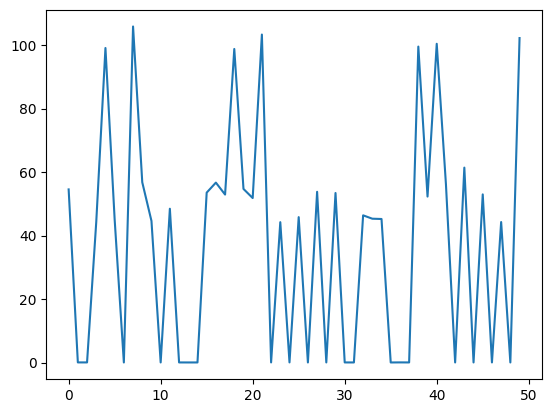

In [27]:
l_all = []
for l in all_loss:
    l_all.append(float(l))
plt.plot(l_all)

# all_loss

In [28]:
import pickle
with open('loss_z.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(l_all, f)